# model tessier nature communications 2022 data

### imports

In [59]:
#standard
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
#preprocessing
from sklearn.preprocessing import OneHotEncoder
#custom
from titeseq_functions import *
from titeseq_modeling import *
from protein_onehotencoder import *
#models and metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### raw data

In [5]:
#get raw data
fit_data_save_location = '/scratch/gthurber_root/gthurber0/marcase/titeseq/'
binary_data = pd.read_csv(fit_data_save_location+'tessier2022_binary.csv')
binary_data = binary_data.loc[:,binary_data.columns[:-1]]
continuous_data = pd.read_csv(fit_data_save_location+'tessier2022_continuous.csv')
varied_sites_manual = np.array([33,50,55,56,57,99,101,104]) - 1 #input varied sites manual as sanity check
varied_sites_manual

array([ 32,  49,  54,  55,  56,  98, 100, 103])

## process data using ProteinOneHotEncoder

### get condensed sequence representation only including varied sites

In [9]:
#minimum number of mutations in a site
threshold = 2
#minimum number of observed mutations needed to include
min_count = 10
#get varying sites
varied_sites = ProteinOneHotEncoder.get_varying_sites(binary_data['VH Sequence'],threshold=threshold,min_count=min_count)
print(f'varied sites as reported: {varied_sites_manual} and varied sites as identified: {varied_sites}')
binary_data['sequence'] = ProteinOneHotEncoder.transform_varying_sites(binary_data['VH Sequence'],threshold=threshold,min_count=min_count)

varied sites as reported: [ 32  49  54  55  56  98 100 103] and varied sites as identified: [ 32  49  54  55  56  98 100 103]


In [35]:
binary_data

,VH Sequence,ANT Binding,OVA Binding,sequence
0,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,0,1,YRTADVGV
1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,1,1,YKGGSDVY
2,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYFMHWVRQAPGQGLE...,0,1,FKRRSVGA
3,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYSMHWVRQAPGQGLE...,1,1,SKAKGAWD
4,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYFMHWVRQAPGQGLE...,0,1,FRERNAAA
...,...,...,...,...
3995,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYFMHWVRQAPGQGLE...,0,0,FTEEGAVD
3996,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYDMHWVRQAPGQGLE...,0,0,DTTGSDWY
3997,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYVMHWVRQAPGQGLE...,0,0,VEKGGSGD
3998,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,0,0,YKAGDDGA


### one hot encode compressed sequences

In [13]:
#one hot encode sequences
enc = ProteinOneHotEncoder()
X_encoded = enc.fit_transform(binary_data['sequence'])
X_encoded

<4000x50 sparse matrix of type '<class 'numpy.float64'>'
	with 32000 stored elements in Compressed Sparse Row format>

### inverse transform

In [15]:
enc.inverse_transform(X_encoded)[:5]

['YRTADVGV', 'YKGGSDVY', 'FKRRSVGA', 'SKAKGAWD', 'FRERNAAA']

### get label

In [36]:
y_binary = binary_data['ANT Binding']

## model data

In [37]:
print(f'Shape of X is {X_encoded.shape} shape of binary y is {y_binary.shape}')

Shape of X is (4000, 50) shape of binary y is (4000,)


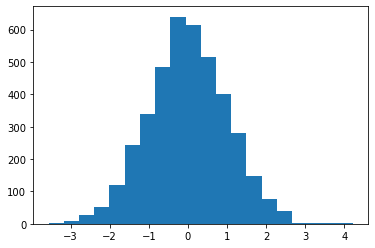

In [54]:
#make up some continuous data for compatibility with the ModelTester class
y_continuous_fake = np.random.normal(0,1,X_encoded.shape[0])

#plot fake distribution
plt.subplot()
hist, bins, _ = plt.hist(y_continuous_fake, bins=20)

Text(0.5, 0, '(fake) continuous target value')

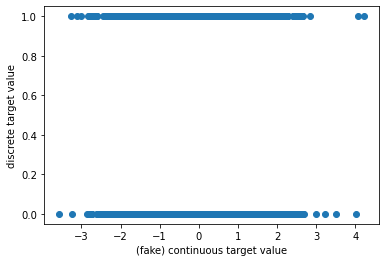

In [56]:
plt.scatter(y_continuous_fake,y_binary) #box and whisker? or shift the data points with some noise to see the density
plt.ylabel('discrete target value')
plt.xlabel('(fake) continuous target value')

In [60]:
#test regression models potential of modeling classification tasks and regression tasks
tester = ModelTester(X_encoded, y_binary,y_continuous_fake)
models = [linear_model.LinearRegression(),linear_model.Ridge(alpha=0.5),linear_model.Lasso(alpha=0.01),svm.SVR(),KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor()]
tester.test_models(models)

Binary mode : LinearRegression: 0.64
Continuous mode : LinearRegression: -0.01
Binary mode : Ridge: 0.64
Continuous mode : Ridge: -0.01
Binary mode : Lasso: 0.61
Continuous mode : Lasso: -0.00
Binary mode : SVR: 0.75
Continuous mode : SVR: -0.10
Binary mode : KNeighborsRegressor: 0.59
Continuous mode : KNeighborsRegressor: -0.22
Binary mode : DecisionTreeRegressor: 0.58
Continuous mode : DecisionTreeRegressor: -1.20
Binary mode : RandomForestRegressor: 0.76
Continuous mode : RandomForestRegressor: -0.11


# go through the process manually

In [16]:
#get compressed sequence form manually
binary_data = binary_data.loc[:,binary_data.columns[:-1]]
binary_data['sequence'] = [getCharsFromString(i,varied_sites) for i in binary_data['VH Sequence']]
binary_data

,VH Sequence,ANT Binding,OVA Binding,sequence
0,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,0,1,YRTADVGV
1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,1,1,YKGGSDVY
2,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYFMHWVRQAPGQGLE...,0,1,FKRRSVGA
3,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYSMHWVRQAPGQGLE...,1,1,SKAKGAWD
4,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYFMHWVRQAPGQGLE...,0,1,FRERNAAA
...,...,...,...,...
3995,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYFMHWVRQAPGQGLE...,0,0,FTEEGAVD
3996,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYDMHWVRQAPGQGLE...,0,0,DTTGSDWY
3997,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYVMHWVRQAPGQGLE...,0,0,VEKGGSGD
3998,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,0,0,YKAGDDGA


In [17]:
#get compressed form for continuous data set
continuous_data = continuous_data[['VH Sequence','ANT Binding', 'OVA Binding']]
continuous_data['sequence'] = [getCharsFromString(i,varied_sites) for i in continuous_data['VH Sequence']]
continuous_data

,VH Sequence,ANT Binding,OVA Binding,sequence
0,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,0.605333,0.851332,YRAEASGA
1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,1.178590,1.081846,YRAKGSGA
2,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,1.497664,0.813501,YRAGSSSD
3,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,1.407028,0.820071,YRRGDSGD
4,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYSMHWVRQAPGQGLE...,0.915810,0.826149,SKKGGAWV
...,...,...,...,...
121,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,1.020216,0.558968,YKRGSSLF
122,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,1.137895,0.590936,YRAGGSLY
123,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYYMHWVRQAPGQGLE...,1.550090,0.554336,YRGRGAAA
124,QVQLVQSGAEVKKPGASVKVSCKASGYTFTDYFMHWVRQAPGQGLE...,0.368642,0.481901,FRTGDSSS


Text(0, 0.5, 'Binding')

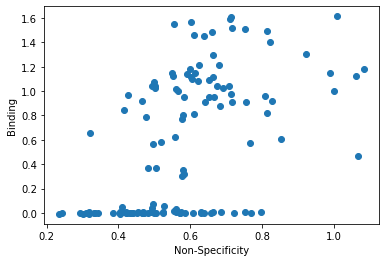

In [18]:
#plot affinity versus specificity for continuous dataset
plt.scatter(continuous_data['OVA Binding'],continuous_data['ANT Binding'])
plt.xlabel('Non-Specificity')
plt.ylabel('Binding')

In [19]:
#encode the sequences limited by the binary dataset into one hot encodings and get the corresponding y vectors for both continuous and binary labels
all_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_acids = list(set(all_amino_acids))
amino_acid_to_index = {aa: i for i, aa in enumerate(amino_acids)}
integer_arrays = [np.array([amino_acid_to_index[aa] for aa in sequence]) for sequence in binary_data['sequence']]
one_hot_encoder = OneHotEncoder(categories="auto")
one_hot_encoded_array = one_hot_encoder.fit_transform(integer_arrays)
one_hot_encoded_array

<4000x50 sparse matrix of type '<class 'numpy.float64'>'
	with 32000 stored elements in Compressed Sparse Row format>

In [20]:
#inverse one hot encode
index_to_amino_acid = {v: k for k, v in amino_acid_to_index.items()}
inverse_transform_AA = one_hot_encoder.inverse_transform(one_hot_encoded_array)
sequence = "".join(amino_acids)

In [21]:
test=[[index_to_amino_acid[i] for i in j] for j in inverse_transform_AA][:5]
test

[['Y', 'R', 'T', 'A', 'D', 'V', 'G', 'V'],
 ['Y', 'K', 'G', 'G', 'S', 'D', 'V', 'Y'],
 ['F', 'K', 'R', 'R', 'S', 'V', 'G', 'A'],
 ['S', 'K', 'A', 'K', 'G', 'A', 'W', 'D'],
 ['F', 'R', 'E', 'R', 'N', 'A', 'A', 'A']]

In [22]:
["".join(i) for i in test]

['YRTADVGV', 'YKGGSDVY', 'FKRRSVGA', 'SKAKGAWD', 'FRERNAAA']

In [23]:
#test new protein one hot encoder
enc = ProteinOneHotEncoder()

In [24]:
#test getting positions that vary based on threshold
differing_positions_threshold = ProteinOneHotEncoder.get_varying_sites(binary_data['VH Sequence'],threshold=1)

In [25]:
#test getting positions that vary based on minimum count observed
differing_positions_min = [i for i in range(len(binary_data['VH Sequence'][0])) if len([s[i] for s in binary_data['VH Sequence'] if s[i] == binary_data['VH Sequence'][0][i]]) < 3990]

In [26]:
#get the intersection of these two sets
np.intersect1d(differing_positions_min,differing_positions_threshold)

array([ 32,  49,  54,  55,  56,  98, 100, 103])

In [27]:
#get the final representation automatically
ProteinOneHotEncoder.transform_varying_sites(binary_data['VH Sequence'])[:5]

['YGLMRTADGRVRSVGVGGV',
 'YGLMKGGSGRVRSDVYGGV',
 'FGLMKRRSGRVRSVGAGGV',
 'SGLMKAKGGRVRSAWDGGV',
 'FGLMRERNGRVRSAAAGGV']

In [28]:
#test fit_transform
X_tr = enc.fit_transform(binary_data['sequence'])

In [29]:
#test fit and transform separately
enc.fit(binary_data['sequence'])
X_tr = enc.transform(binary_data['sequence'])

In [30]:
X_tr

<4000x50 sparse matrix of type '<class 'numpy.float64'>'
	with 32000 stored elements in Compressed Sparse Row format>

In [31]:
enc.inverse_transform(X_tr)[:5]

['YRTADVGV', 'YKGGSDVY', 'FKRRSVGA', 'SKAKGAWD', 'FRERNAAA']

In [32]:
# Zip the strings together so that we can iterate over them in parallel
zipped_strings = binary_data['VH Sequence']

# Iterate over the zipped strings and compare the characters at each position
differing_positions = [i for i in range(len(binary_data['VH Sequence'][0])) if len(set([s[i] for s in zipped_strings])) > 1]

In [33]:
differing_positions

[18,
 21,
 32,
 33,
 36,
 37,
 41,
 42,
 43,
 44,
 45,
 47,
 49,
 50,
 54,
 55,
 56,
 57,
 64,
 65,
 66,
 67,
 80,
 86,
 87,
 97,
 98,
 100,
 102,
 103,
 104,
 105,
 107,
 110,
 114]

In [34]:
[set(binary_data['VH Sequence'].str[i]) for i in differing_positions]

[{'K', 'N'},
 {'C', 'Y'},
 {'A', 'D', 'F', 'S', 'V', 'Y'},
 {'I', 'M'},
 {'I', 'V'},
 {'K', 'R'},
 {'D', 'G'},
 {'Q', 'R'},
 {'D', 'G'},
 {'F', 'L', 'S'},
 {'E', 'K'},
 {'I', 'M'},
 {'A', 'E', 'G', 'K', 'M', 'R', 'T'},
 {'A', 'V'},
 {'A', 'E', 'G', 'K', 'R', 'T'},
 {'A', 'E', 'G', 'K', 'R', 'T'},
 {'A', 'D', 'G', 'N', 'S', 'T'},
 {'I', 'T'},
 {'E', 'K'},
 {'G', 'S'},
 {'H', 'R'},
 {'I', 'V'},
 {'I', 'M'},
 {'K', 'R'},
 {'F', 'S'},
 {'K', 'R'},
 {'A', 'D', 'F', 'S', 'V', 'Y'},
 {'A', 'G', 'L', 'S', 'V', 'W'},
 {'D', 'N'},
 {'A', 'D', 'F', 'S', 'T', 'V', 'Y'},
 {'R', 'W'},
 {'G', 'S'},
 {'D', 'G', 'S'},
 {'I', 'V'},
 {'F', 'S'}]